# Resultados Desde Artefactos Guardados

Este notebook NO re-entrena ni re-extrae embeddings. Solo usa artefactos ya generados en `outputs_02_mert_finetune_egfxset`.

Evaluación principal: **Val→Train**.


1. Carga de artefactos


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

SEED = 42
OUT_DIR_02 = Path("./outputs_02_mert_finetune_egfxset")
LABEL_COL = "tone_pickup"

FT_TRAIN_EMBS_PATH  = OUT_DIR_02 / "mert_ft_embs_train.npy"
FT_VAL_EMBS_PATH    = OUT_DIR_02 / "mert_ft_embs_val.npy"
FT_TRAIN_INDEX_PATH = OUT_DIR_02 / "egfxset_index_used_train.csv"
FT_VAL_INDEX_PATH   = OUT_DIR_02 / "egfxset_index_used_val.csv"

for p in [FT_TRAIN_EMBS_PATH, FT_VAL_EMBS_PATH, FT_TRAIN_INDEX_PATH, FT_VAL_INDEX_PATH]:
    assert p.exists(), f"Falta artefacto: {p}"

train_df = pd.read_csv(FT_TRAIN_INDEX_PATH)
val_df   = pd.read_csv(FT_VAL_INDEX_PATH)
X_train = np.load(FT_TRAIN_EMBS_PATH)
X_val   = np.load(FT_VAL_EMBS_PATH)

assert len(train_df) == X_train.shape[0], (len(train_df), X_train.shape)
assert len(val_df)   == X_val.shape[0], (len(val_df), X_val.shape)

classes = sorted(pd.concat([train_df[LABEL_COL], val_df[LABEL_COL]]).astype(str).unique().tolist())
class2id = {c: i for i, c in enumerate(classes)}
y_train = train_df[LABEL_COL].astype(str).map(class2id).to_numpy()
y_val   = val_df[LABEL_COL].astype(str).map(class2id).to_numpy()

chance = 1.0 / len(classes)
print("X_train:", X_train.shape, "| X_val:", X_val.shape)
print("num_classes:", len(classes), "| chance:", chance)


X_train: (7157, 256) | X_val: (1790, 256)
num_classes: 65 | chance: 0.015384615384615385


2. Retrieval (Val→Train)


In [2]:
def l2_normalize(X, eps=1e-12):
    denom = np.linalg.norm(X, axis=1, keepdims=True)
    denom = np.maximum(denom, eps)
    return X / denom

def topk_retrieval_metrics(X_queries, y_queries, X_gallery, y_gallery, k_list=(1, 5), exclude_self=False):
    Xq = l2_normalize(X_queries.astype(np.float32))
    Xg = l2_normalize(X_gallery.astype(np.float32))
    S = Xq @ Xg.T

    if exclude_self:
        assert S.shape[0] == S.shape[1], "exclude_self requiere queries==gallery"
        np.fill_diagonal(S, -np.inf)

    maxK = max(k_list)
    top_idx = np.argpartition(-S, kth=maxK-1, axis=1)[:, :maxK]
    row = np.arange(S.shape[0])[:, None]
    top_idx = top_idx[row, np.argsort(-S[row, top_idx], axis=1)]

    retrieved = y_gallery[top_idx]

    metrics = {}
    for k in k_list:
        hit = (retrieved[:, :k] == y_queries[:, None]).any(axis=1)
        metrics[f"top_{k}"] = float(hit.mean())

    y_pred_top1 = retrieved[:, 0].copy()
    return metrics, y_pred_top1


In [3]:
results = []

# Evaluación principal de generalización
m_v2t, pred_v2t = topk_retrieval_metrics(
    X_val, y_val, X_train, y_train,
    k_list=(1, 5), exclude_self=False
)
results.append(("MERT fine-tuned", "Val→Train (retrieval)", X_train.shape[1], m_v2t["top_1"], m_v2t["top_5"]))

res_df = pd.DataFrame(results, columns=["Modelo", "Configuración", "Dimensión", "Top-1", "Top-5"])
res_df["Chance (1/C)"] = chance
res_df["Top-1 vs chance"] = res_df["Top-1"] / chance
display(res_df)

OUT_TABLE = OUT_DIR_02 / "results_retrieval_mert_ft_val_to_train.csv"
res_df.to_csv(OUT_TABLE, index=False)
print("Saved:", OUT_TABLE)


,Modelo,Configuración,Dimensión,Top-1,Top-5,Chance (1/C),Top-1 vs chance
0,MERT fine-tuned,Val→Train (retrieval),256,0.960894,0.972067,0.015385,62.458101


Saved: outputs_02_mert_finetune_egfxset/results_retrieval_mert_ft_val_to_train.csv


3. Confusión Top-1 (Val→Train)


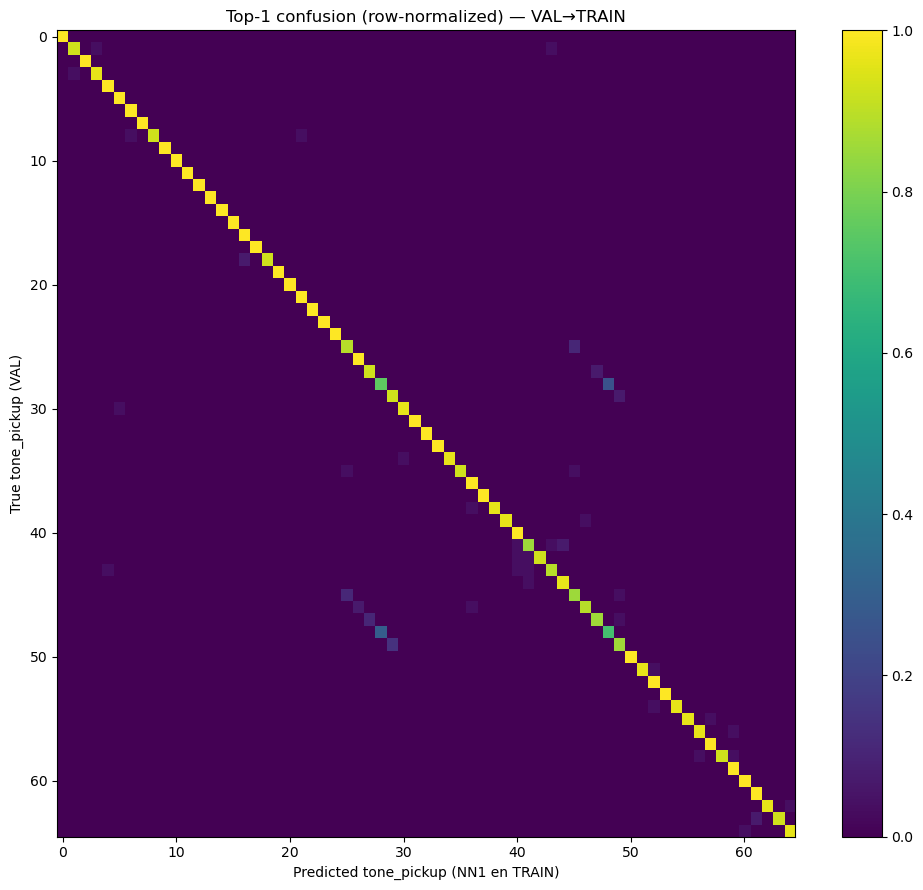

row_0                         col_0                       
Spring Reverb__Middle-Neck    Hall Reverb__Middle-Neck        8
Hall Reverb__Middle-Neck      Spring Reverb__Middle-Neck      7
Spring Reverb__Neck           Hall Reverb__Neck               4
Spring Reverb__Middle         Hall Reverb__Middle             3
Spring Reverb__Bridge         Hall Reverb__Bridge             3
Hall Reverb__Bridge           Spring Reverb__Bridge           3
TubeScreamer__Middle-Neck     TubeScreamer__Bridge-Middle     2
Digital Delay__Middle-Neck    Digital Delay__Bridge-Middle    2
RAT__Bridge-Middle            RAT__Neck                       2
Hall Reverb__Neck             Spring Reverb__Neck             2
Hall Reverb__Middle           Spring Reverb__Middle           2
Spring Reverb__Bridge-Middle  Hall Reverb__Bridge-Middle      2
Spring Reverb__Middle         Spring Reverb__Neck             1
RAT__Bridge-Middle            RAT__Bridge                     1
BluesDriver__Bridge-Middle    BluesDriver__Mi

Saved: outputs_02_mert_finetune_egfxset/topconf_val_to_train_mert_ft.csv


In [4]:
def top1_confusion_val_to_train(X_query, labels_query_str, X_gallery, labels_gallery_str, title):
    Xq = X_query.astype(np.float32)
    Xg = X_gallery.astype(np.float32)
    Xq = Xq / (np.linalg.norm(Xq, axis=1, keepdims=True) + 1e-9)
    Xg = Xg / (np.linalg.norm(Xg, axis=1, keepdims=True) + 1e-9)

    S = Xq @ Xg.T
    nn1 = np.argmax(S, axis=1)

    y_true = labels_query_str.astype(str)
    y_pred = labels_gallery_str[nn1].astype(str)

    cm = pd.crosstab(y_true, y_pred)
    cm = cm.reindex(index=sorted(cm.index), columns=sorted(cm.columns), fill_value=0)
    cm_norm = cm.div(cm.sum(axis=1).replace(0, 1), axis=0)

    plt.figure(figsize=(10, 9))
    plt.imshow(cm_norm.to_numpy(), aspect="auto")
    plt.title(title)
    plt.xlabel("Predicted tone_pickup (NN1 en TRAIN)")
    plt.ylabel("True tone_pickup (VAL)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    cm_off = cm.copy()
    diag_labels = sorted(set(cm_off.index).intersection(set(cm_off.columns)))
    for k in diag_labels:
        cm_off.loc[k, k] = 0
    top_conf = cm_off.stack().sort_values(ascending=False).head(20)
    return cm, cm_norm, top_conf

labels_train = train_df[LABEL_COL].astype(str).to_numpy()
labels_val = val_df[LABEL_COL].astype(str).to_numpy()

cm_v2t, cmn_v2t, topconf_v2t = top1_confusion_val_to_train(
    X_val,
    labels_val,
    X_train,
    labels_train,
    title="Top-1 confusion (row-normalized) — VAL→TRAIN"
)

display(topconf_v2t)

OUT_TOPCONF = OUT_DIR_02 / "topconf_val_to_train_mert_ft.csv"
topconf_v2t.to_csv(OUT_TOPCONF, header=["count"])
print("Saved:", OUT_TOPCONF)

4. t-SNE de embeddings guardados (Train y Val)


t-SNE TRAIN: precomputed
t-SNE VAL: precomputed
Saved: outputs_02_mert_finetune_egfxset/figures_mert_ft/mert_ft_tsne_global_train_tone_pickup.png


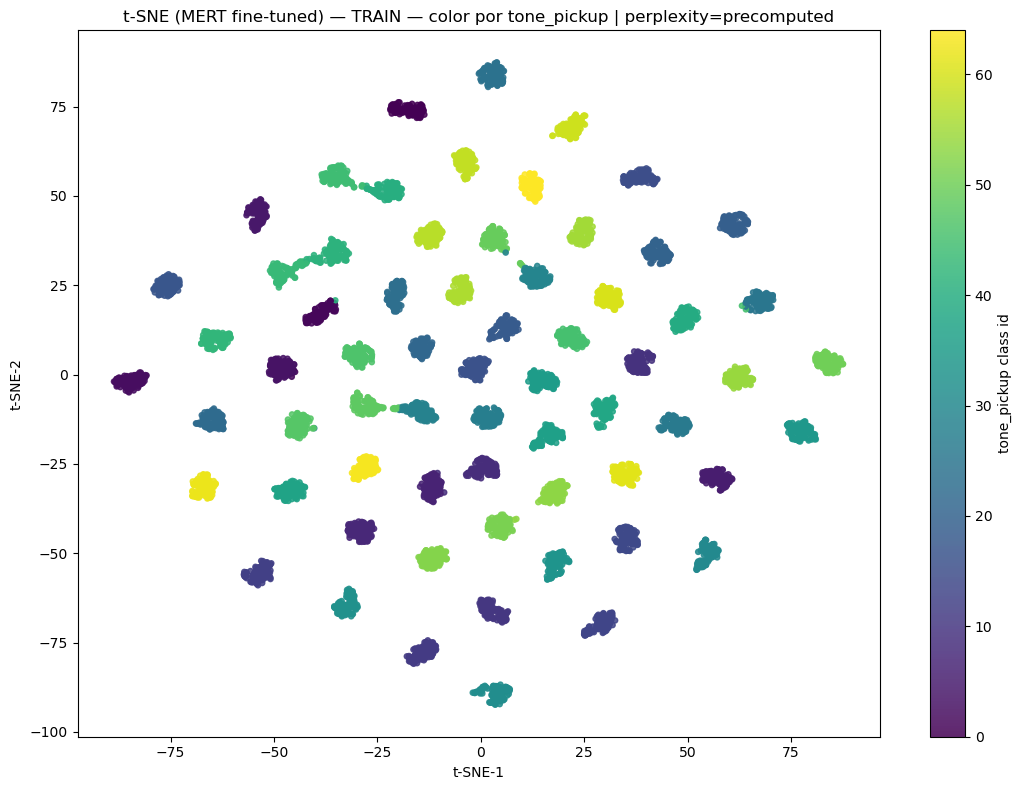

Saved: outputs_02_mert_finetune_egfxset/figures_mert_ft/mert_ft_tsne_global_val_tone_pickup.png


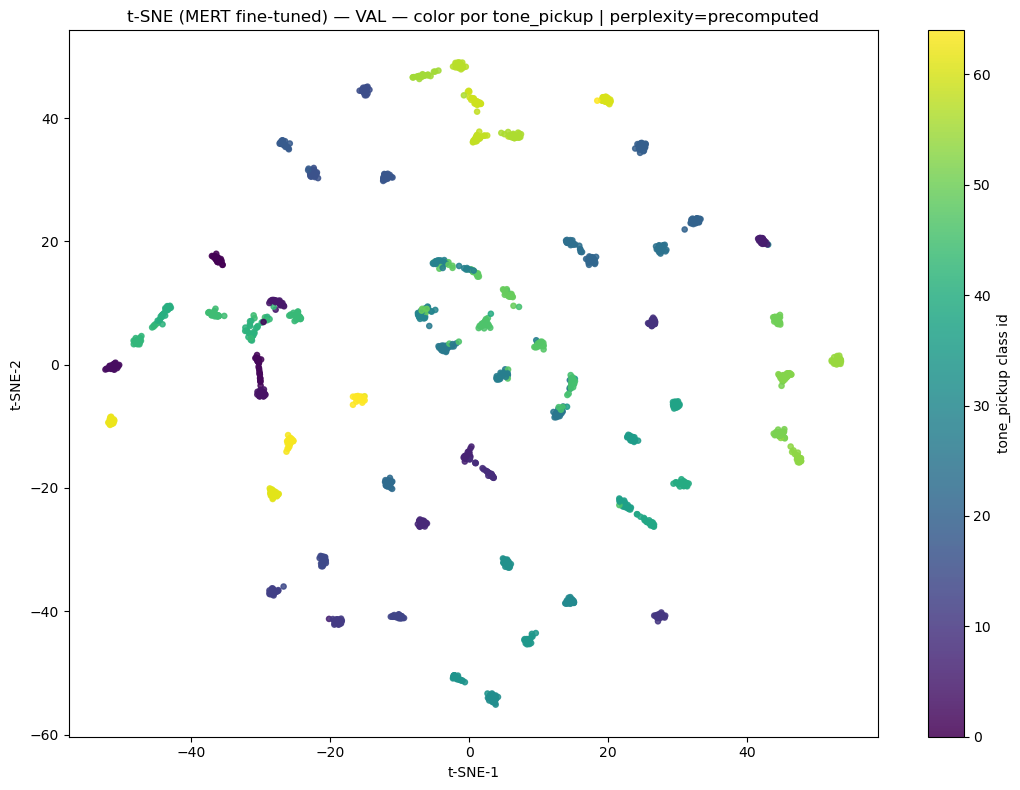

Saved: outputs_02_mert_finetune_egfxset/figures_mert_ft/mert_ft_tsne_subplots_train_tone_color_pickup.png


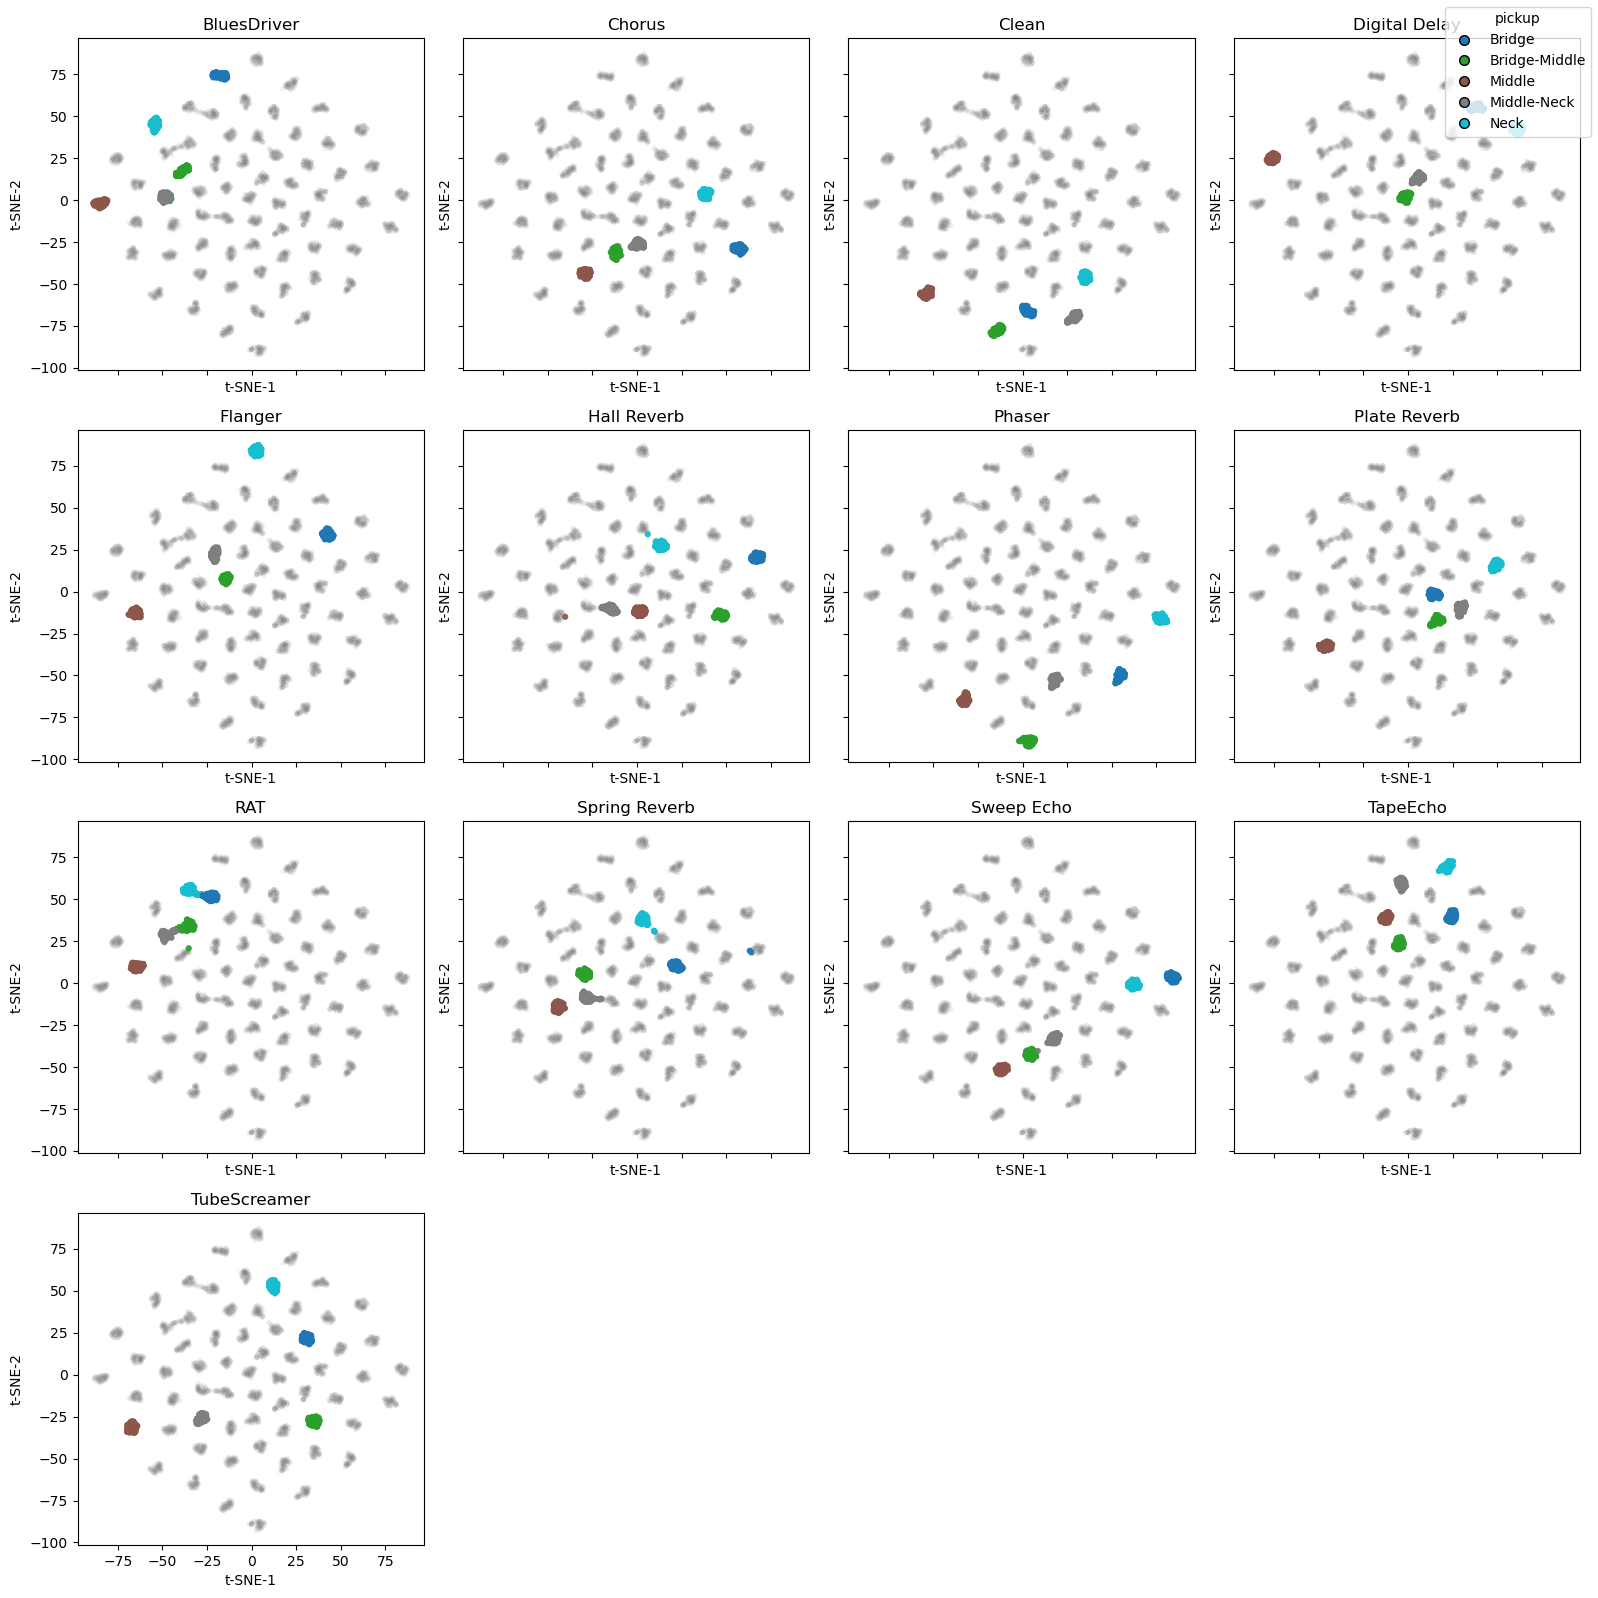

Saved: outputs_02_mert_finetune_egfxset/figures_mert_ft/mert_ft_tsne_subplots_val_tone_color_pickup.png


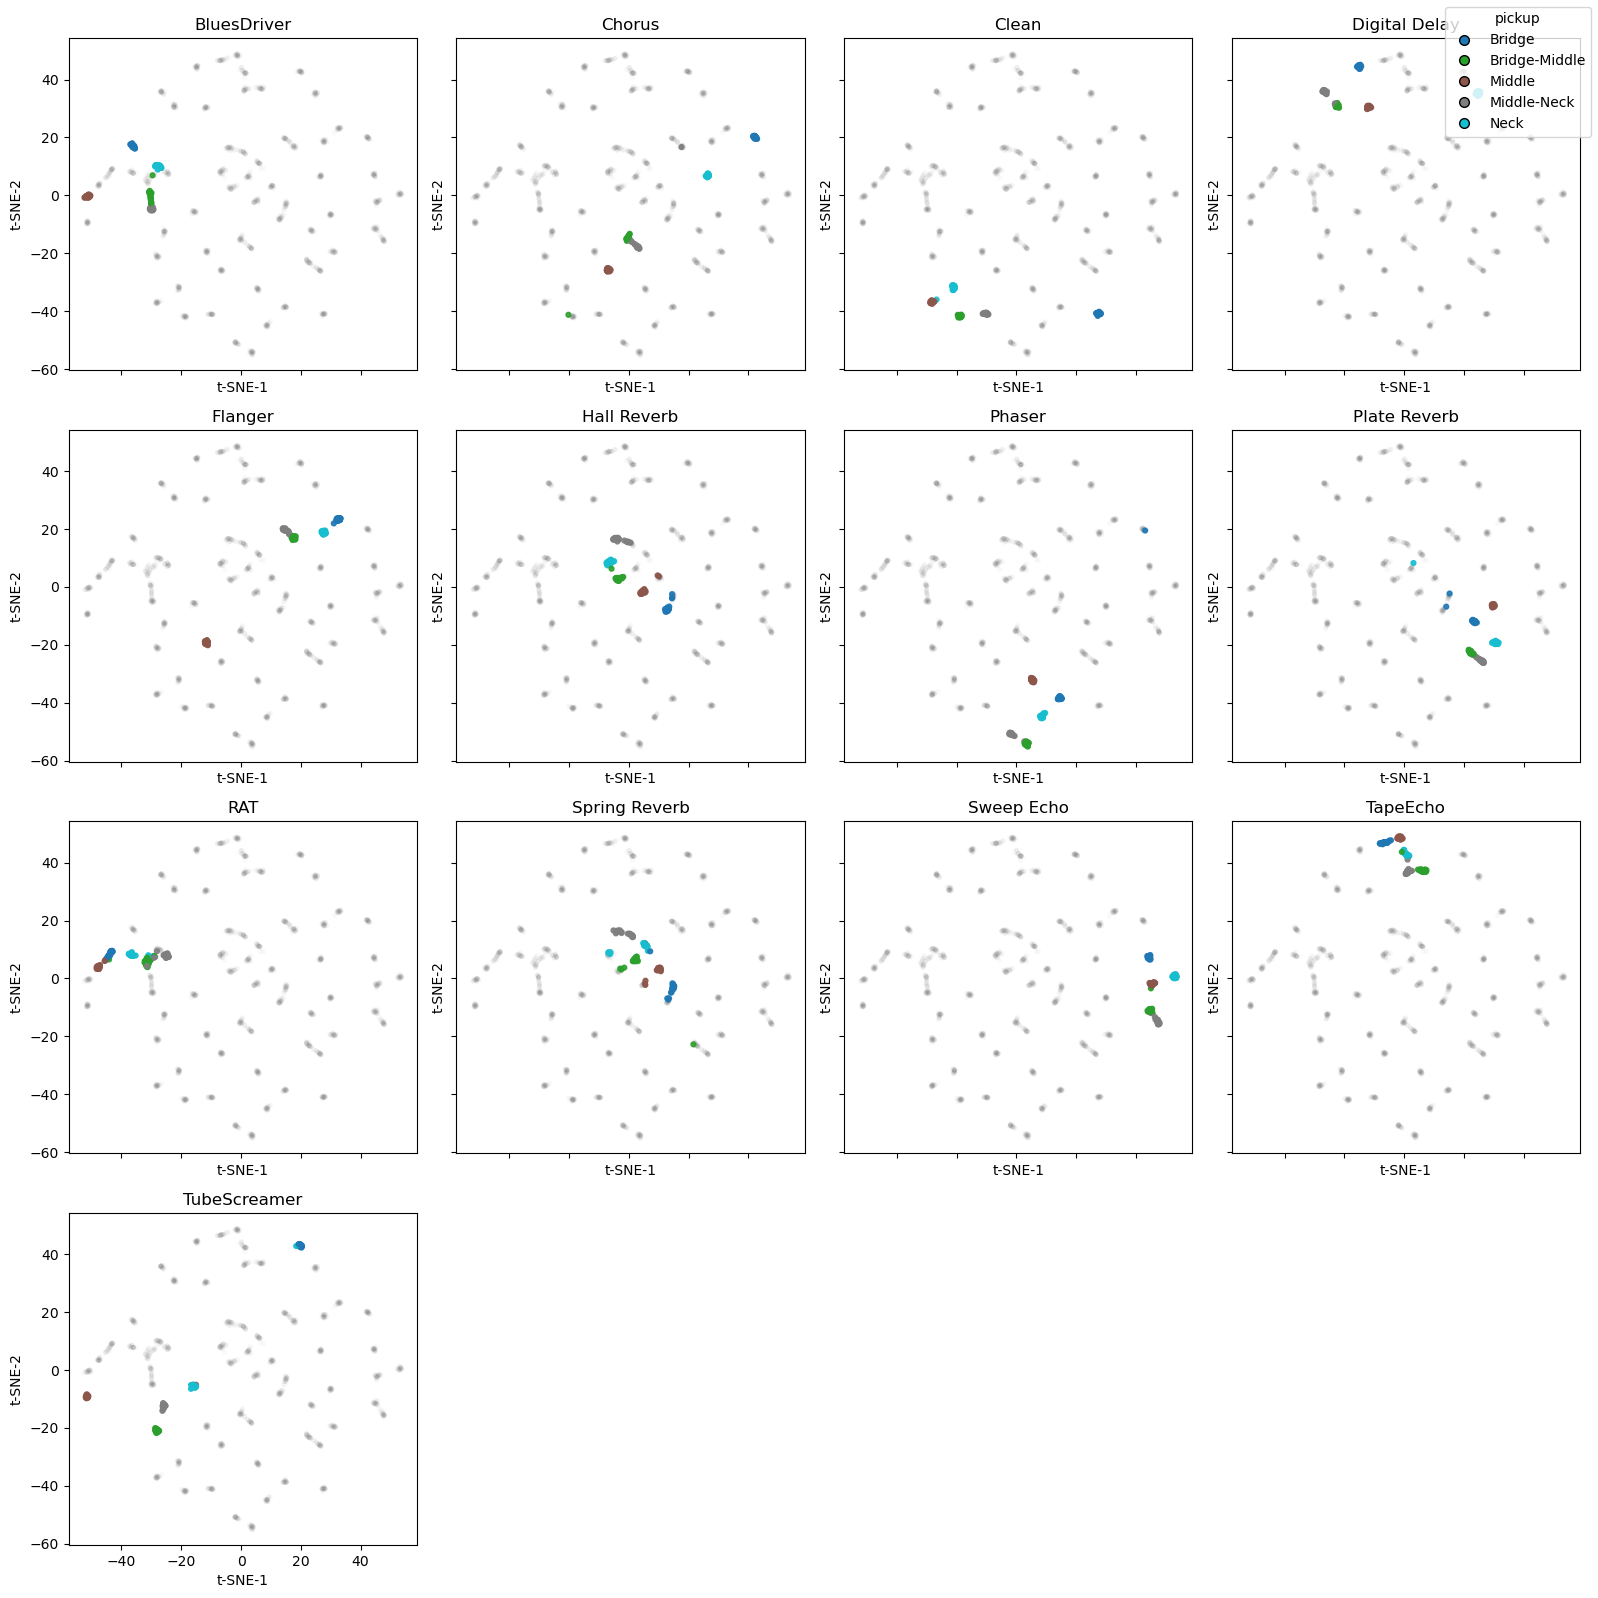

In [5]:
FIG_DIR = OUT_DIR_02 / "figures_mert_ft"
FIG_DIR.mkdir(parents=True, exist_ok=True)

TSNE_TRAIN_PATH = OUT_DIR_02 / "tsne_train_mert_ft.npy"
TSNE_VAL_PATH = OUT_DIR_02 / "tsne_val_mert_ft.npy"

def savefig(fig, name, dpi=300):
    name = name if name.lower().endswith(".png") else f"{name}.png"
    out = FIG_DIR / name
    fig.savefig(out, dpi=dpi, bbox_inches="tight")
    print("Saved:", out)

def tsne_fit_like_original(X, random_state=42):
    X = X.astype(np.float32)
    X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)
    pca_dim = min(50, X.shape[1])
    X_pca = PCA(n_components=pca_dim, random_state=random_state).fit_transform(X)
    N = X_pca.shape[0]
    perplexity = max(5, min(30, (N - 1) // 3))

    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        init="pca",
        learning_rate="auto",
        random_state=random_state,
    )
    Z = tsne.fit_transform(X_pca)
    return Z, perplexity

def plot_tsne_global(Z, labels_tone_pickup, title, fig_name):
    uniq = sorted(set(labels_tone_pickup.tolist()))
    lab2i = {u: i for i, u in enumerate(uniq)}
    c = np.array([lab2i[x] for x in labels_tone_pickup], dtype=int)

    plt.figure(figsize=(11, 8))
    plt.scatter(Z[:, 0], Z[:, 1], c=c, s=14, alpha=0.85)
    plt.title(title)
    plt.xlabel("t-SNE-1")
    plt.ylabel("t-SNE-2")
    cb = plt.colorbar()
    cb.set_label("tone_pickup class id")
    plt.tight_layout()
    savefig(plt.gcf(), fig_name)
    plt.show()
    plt.close(plt.gcf())

labels_train = train_df[LABEL_COL].astype(str).to_numpy()
labels_val = val_df[LABEL_COL].astype(str).to_numpy()

if TSNE_TRAIN_PATH.exists():
    Z_train = np.load(TSNE_TRAIN_PATH)
    perp_train = "precomputed"
else:
    Z_train, perp_train = tsne_fit_like_original(X_train, random_state=SEED)
    np.save(TSNE_TRAIN_PATH, Z_train)

if TSNE_VAL_PATH.exists():
    Z_val = np.load(TSNE_VAL_PATH)
    perp_val = "precomputed"
else:
    Z_val, perp_val = tsne_fit_like_original(X_val, random_state=SEED)
    np.save(TSNE_VAL_PATH, Z_val)

print("t-SNE TRAIN:", perp_train)
print("t-SNE VAL:", perp_val)

plot_tsne_global(
    Z_train,
    labels_train,
    title=f"t-SNE (MERT fine-tuned) — TRAIN — color por tone_pickup | perplexity={perp_train}",
    fig_name="mert_ft_tsne_global_train_tone_pickup"
)
plot_tsne_global(
    Z_val,
    labels_val,
    title=f"t-SNE (MERT fine-tuned) — VAL — color por tone_pickup | perplexity={perp_val}",
    fig_name="mert_ft_tsne_global_val_tone_pickup"
)


def plot_tsne_subplots_by_tone_color_pickup(Z, df_subset, fig_name):
    if not {"tone", "pickup"}.issubset(set(df_subset.columns)):
        print("SKIP subplots: faltan columnas 'tone' y/o 'pickup' en df_subset.")
        return

    tones = sorted(df_subset["tone"].astype(str).unique())
    pickups = sorted(df_subset["pickup"].astype(str).unique())

    p2i = {p: i for i, p in enumerate(pickups)}
    pickup_ids = df_subset["pickup"].astype(str).map(p2i).to_numpy()

    cmap = plt.get_cmap("tab10", len(pickups))

    n = len(tones)
    ncols = 4
    nrows = (n + ncols - 1) // ncols

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(16, 4 * nrows),
        sharex=True,
        sharey=True
    )
    axes = np.array(axes).reshape(-1)

    tone_arr = df_subset["tone"].astype(str).to_numpy()

    for ax, t in zip(axes, tones):
        m = (tone_arr == t)

        ax.scatter(
            Z[~m, 0], Z[~m, 1],
            s=8, alpha=0.03, color="grey"
        )

        ax.scatter(
            Z[m, 0], Z[m, 1],
            c=pickup_ids[m],
            cmap=cmap,
            s=12,
            alpha=0.9,
            vmin=0,
            vmax=len(pickups) - 1
        )

        ax.set_title(t)
        ax.set_xlabel("t-SNE-1")
        ax.set_ylabel("t-SNE-2")

    for k in range(len(tones), len(axes)):
        axes[k].axis("off")

    handles = [
        plt.Line2D(
            [0], [0],
            marker='o',
            linestyle='',
            markersize=7,
            markerfacecolor=cmap(i),
            markeredgecolor='black',
            label=p
        )
        for p, i in p2i.items()
    ]

    fig.legend(handles=handles, title="pickup", loc="upper right")

    plt.tight_layout()
    savefig(fig, fig_name)
    plt.show()
    plt.close(fig)

plot_tsne_subplots_by_tone_color_pickup(
    Z_train,
    train_df,
    fig_name="mert_ft_tsne_subplots_train_tone_color_pickup"
)
plot_tsne_subplots_by_tone_color_pickup(
    Z_val,
    val_df,
    fig_name="mert_ft_tsne_subplots_val_tone_color_pickup"
)